### notes
1. нужно ли хранить в выходном массиве непосредственно сами фичи? или отрисовывать боксы на изображениях сразу, не выходя из цикла? 
2. что делать с объектами, которые пропадают из поля зрения?
3. **что делать с объектами, для которых нашлась всего одна фича? просто удалять?** (есть прикольная мысль о том, как связан объем изображения с количеством найденных фич - мб есть смысл отбрасывать объекты еще на этапе выделения фрагмента изображения)
4. все-таки вопрос об идеальной структуре данных остается неотвеченным (хотя **надо просто попробовать разные**)

In [102]:
import os
from cv2 import cv2
import yaml
import re
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from collections import Counter

In [2]:
# параметра отображения картинок внутри блокнота
plt.rcParams['figure.figsize'] = [13, 7]

### Вспомогательные функции

In [3]:
def readYAMLFile(file):
    ret = {}
    skip_lines = 1    # Skip the first line which says "%YAML:1.0". Or replace it with "%YAML 1.0"
    with open(file) as fin:
        for i in range(skip_lines):
            fin.readline()
        yamlFileOut = fin.read()
        myRe = re.compile(r":([^ ])")   # Add space after ":", if it doesn't exist. Python yaml requirement
        yamlFileOut = myRe.sub(r': \1', yamlFileOut)
        ret = yaml.safe_load(yamlFileOut)
    return ret

In [4]:
# расстояние между двумя точками
def dist(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5

In [5]:
# оставляем только нужные ключи
def convert_object(image, obj):
    # converted = {key: obj[key] for key in ['x_min', 'y_min', 'x_max', 'y_max']}
    # converted['flow'] = []
    
    converted = {
        'id': obj['id'],
        'flow': [
            {key: obj[key] for key in ['x_min', 'y_min', 'x_max', 'y_max']}
        ]
        
    }
    
    converted['flow'][-1]['frame_id'] = image[18:-4]
    
    return converted

In [6]:
def get_frame(object_, p0, p1):
    
    # центр рамки объекта на первом кадре
    center_1 = np.array([(object_['flow'][-1]['x_min'] + object_['flow'][-1]['x_max']) / 2, 
                         (object_['flow'][-1]['y_min'] + object_['flow'][-1]['y_max']) / 2], 
                                                                                    dtype='float32')
    
    
    centroid_1, centroid_2 = [x.mean(axis=-2) for x in [p0, p1]]
    
    
    dist_between_points_1 = np.array([dist(p0[i], p0[j]) for i in range(len(p0)) 
                                                for j in range(i + 1, len(p0))]).mean()
    dist_between_points_2 = np.array([dist(p1[i], p1[j]) for i in range(len(p1)) 
                                                for j in range(i + 1, len(p1))]).mean()
    
    
    scale = dist_between_points_1 / dist_between_points_2
    difference = (center_1 - centroid_1) / scale
        
    # параметры новой рамки
    center_2 = centroid_2 + difference
    width_2, height_2 = (object_['flow'][-1]['x_max'] - object_['flow'][-1]['x_min']) / scale, \
                        (object_['flow'][-1]['y_max'] - object_['flow'][-1]['y_min']) / scale
            
        
    # итог: координаты предсказанной рамки    
    x_min = int(round(center_2[0] - width_2 / 2))
    y_min = int(round(center_2[1] - height_2 / 2))
    x_max = int(round(center_2[0] + width_2 / 2))
    y_max = int(round(center_2[1] + height_2 / 2))
        
        
    return {'x_min': x_min,'y_min': y_min,'x_max': x_max,'y_max': y_max}
    

In [432]:
# intersection over union
def get_intersection(box_1, box_2):
    #flag = 0
    
    # координаты прямоугольника - пересечения
    x_min = max(box_1['x_min'], box_2['x_min'])
    y_min = max(box_1['y_min'], box_2['y_min'])
    x_max = min(box_1['x_max'], box_2['x_max'])
    y_max = min(box_1['y_max'], box_2['y_max'])
    
    
    if x_max < x_min or y_max < y_min:
        return -1#, flag
    
    
    intersection_area = (x_max - x_min) * (y_max - y_min)
    box_1_area = (box_1['x_max'] - box_1['x_min']) * (box_1['y_max'] - box_1['y_min'])
    box_2_area = (box_2['x_max'] - box_2['x_min']) * (box_2['y_max'] - box_2['y_min'])
    
    smallest = min(box_1_area, box_2_area)
    #if smallest == box_2_area:
    #    flag = 1
    
    
    return intersection_area / smallest#, flag
           # intersection_area / (box_1_area + box_2_area - intersection_area) - IOU

### Данные

In [455]:
imgs_path = 'images/cam0/'
frms_path = 'frames/cam0/'

images = sorted([imgs_path + x for x in os.listdir(imgs_path) if x.endswith('.png')])
frames = sorted([frms_path + x for x in os.listdir(frms_path) if x.endswith('.yml')])

In [406]:
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('neuro_only.avi', fourcc, 10.0, (1280, 720))

while images:
    img = cv2.imread(images[0], cv2.IMREAD_COLOR)
    objects = readYAMLFile(frames[0])['boxes']
    
    for obj in objects:
        x_min, y_min, x_max, y_max = list(obj.values())[-4:]
        img = cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
        
    out.write(img)
    
    images = images[1:]
    frames = frames[1:]
    
out.release()

### Оптический поток
+ в данном случае используем SIFT (вообще говоря, не единственный возможный вариант)

In [10]:
# lucas-kanade parameters
lk_params = dict(winSize  = (15, 15),
                 maxLevel = 2,
                 criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

sift = cv2.SIFT_create()

In [456]:
# объекты, которые трекаются на рассматриваемом кадре
objects = []

# объекты, которые перестали трекаться
gone = []

# пары объектов "бокс с оптического потока" -> "бокс с нейронки", у которых iou > 0.5
merged = []

# отвалился по причине "мало фич"
small_p0 = []

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('optical_flow-visualisation.avi', fourcc, 2.0, (1280, 720))


while len(images) > 1:
    
    # 1 и 2 кадр
    old_image, image = [cv2.imread(images[i], cv2.IMREAD_COLOR) for i in range(2)]
    old_gray, gray = [cv2.cvtColor(x, cv2.COLOR_BGR2GRAY) for x in [old_image, image]]
    
    # условие для 0 шага
    if not objects:
        # за исходный набор объектов берем предсказания нейросети для 1 кадра
        objects = [convert_object(images[0], x) for x in readYAMLFile(frames[0])['boxes']]
        
        # отрисовка самого первого кадра
        for obj in objects:
            id_ = obj['id']
            x_min, y_min, x_max, y_max = list(obj['flow'][-1].values())[:4]
            old_image = cv2.rectangle(old_image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            old_image = cv2.putText(old_image, f'{id_}', (x_min - 40, y_min - 10), \
                                            cv2.FONT_HERSHEY_COMPLEX, 0.5, (255, 255, 255), 1)
        
        out.write(old_image)
        
        
    # набор боксов, предсказанный нейронкой для следующего кадра
    new_neuro_objects = [x for x in readYAMLFile(frames[1])['boxes']]
    
    to_be_removed = []    
    for obj in objects:
        # вырезанный кусок изображения, содержащий объект obj
        cut = old_gray[obj['flow'][-1]['y_min']:obj['flow'][-1]['y_max'], \
                           obj['flow'][-1]['x_min']:obj['flow'][-1]['x_max']]
           
        
        # набор сифтовых фичей для объекта obj
        p0 = cv2.KeyPoint_convert(sift.detect(cut, None))
        
        
        # отлов случая с всего одной найденной фичой
        # далее этот объект не рассматривается
        if len(p0) <= 2:
            gone.append(obj)
            to_be_removed.append(obj)
            small_p0.append(obj['id'])
            continue
        
        p0 = np.array(p0 + (obj['flow'][-1]['x_min'], obj['flow'][-1]['y_min']), dtype='float32')
        
        
        # набор фичей для следующего кадра, посчитанные оптическим потоком
        # (вылетает Assertion error, когда в p0 лежит всего одна фича)
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, gray, p0, None, **lk_params)
        p1 = p1[np.all(st==1, axis=-1)]
        
        
        # получение набора координат для нового бокса
        obj['flow'].append(get_frame(obj, p0, p1))
        obj['flow'][-1]['frame_id'] = images[1][18:-4]
        
        
        # блок сравнения списка объектов с оптического потока и с нейронки
        for new in new_neuro_objects:
            
            # отрисовка бокса с нейронки
            id_ = new['id']
            x_min, y_min, x_max, y_max = list(new.values())[-4:]
            image = cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 255), 2)
            
            if y_min > 75:
                image = cv2.putText(image, f'{id_}', (x_max - 30, y_max + 20), \
                                            cv2.FONT_HERSHEY_COMPLEX, 0.5, (255, 255, 255), 1)
            
            
            # сравнение боксов с нейронки и с потока посредством метрики intersection over smallest
            k = get_intersection(new, obj['flow'][-1])
            if k > 0.6:
                merged.append((new['id'], obj['id'], images[1][18:-4]))
                new_neuro_objects.remove(new)
        
        
        # отрисовка бокса, предсказанного с оптического потока 
        id_ = obj['id']
        x_min, y_min, x_max, y_max = list(obj['flow'][-1].values())[:4]
        
        image = cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        
        if y_min > 75:
            image = cv2.putText(image, f'{id_}', (x_min - 40, y_min - 10), \
                                            cv2.FONT_HERSHEY_COMPLEX, 0.5, (255, 255, 255), 1)
        
        
        
        
    for x in to_be_removed:
        gone.append(x)
        objects.remove(x)
    
    
    # блок перехода на следующий шаг
    
    objects += [convert_object(images[1], x) for x in new_neuro_objects]
    images = images[1:]
    frames = frames[1:]
    out.write(image)

out.release()

In [457]:
merged

[(31635, 31630, '10241'),
 (31636, 31631, '10241'),
 (31634, 31632, '10241'),
 (31639, 31630, '10242'),
 (31640, 31631, '10242'),
 (31638, 31632, '10242'),
 (31645, 31631, '10243'),
 (31643, 31632, '10243'),
 (31647, 31641, '10243'),
 (31650, 31631, '10244'),
 (31648, 31632, '10244'),
 (31652, 31641, '10244'),
 (31649, 31644, '10244'),
 (31657, 31631, '10245'),
 (31654, 31632, '10245'),
 (31655, 31644, '10245'),
 (31661, 31631, '10246'),
 (31659, 31632, '10246'),
 (31660, 31644, '10246'),
 (31667, 31631, '10247'),
 (31664, 31632, '10247'),
 (31665, 31644, '10247'),
 (31669, 31632, '10248'),
 (31670, 31644, '10248'),
 (31672, 31666, '10248'),
 (31674, 31632, '10249'),
 (31677, 31641, '10249'),
 (31675, 31644, '10249'),
 (31676, 31671, '10249'),
 (31678, 31632, '10250'),
 (31679, 31641, '10250'),
 (31680, 31644, '10250'),
 (31681, 31671, '10250'),
 (31683, 31632, '10251'),
 (31685, 31641, '10251'),
 (31684, 31644, '10251'),
 (31686, 31671, '10251'),
 (31688, 31632, '10252'),
 (31690, 316

In [416]:
# маленькие треки
fails = [obj for obj in gone if len(obj['flow']) == 1]
lengthes = Counter([len(obj['flow']) for obj in objects])
lengthes

Counter({59: 1, 42: 1, 27: 1, 1: 3})

In [197]:
# большие треки 
tracks = []

tracks += [obj for obj in objects if len(obj['flow']) > 1]
tracks += [obj for obj in gone if len(obj['flow']) > 2]
len(tracks)

1

In [198]:
# ни один трек не обрывается в процессе (взята последовательность кадров с простейшей ситуацией)
tr = [int(x['frame_id']) for x in tracks[0]['flow']]
tr == list(range(tr[0], tr[-1] + 1))

True

In [199]:
def square(obj):
    data = obj['flow'][0]
    return (data['x_max'] - data['x_min']) * ((data['y_max'] - data['y_min']))

Text(0.5, 1.0, 'площадь бокса у объектов с треком длины = 1')

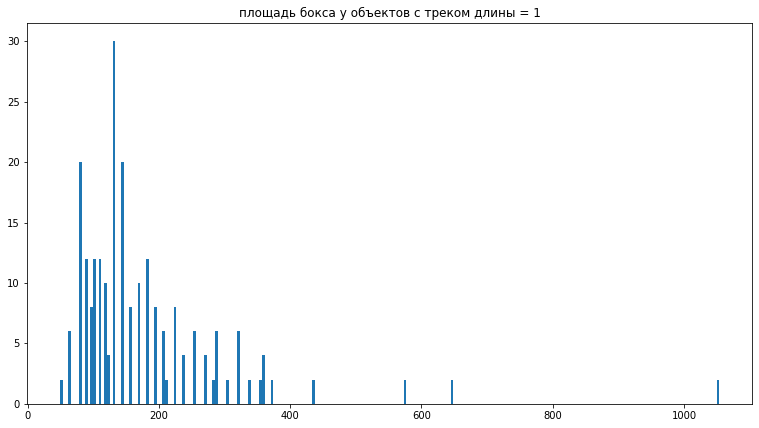

In [200]:
to_hist = [square(x) for x in fails]

fig, ax = plt.subplots()
n_bins = len(to_hist)
ax.hist(to_hist, bins=n_bins)
ax.set_title('площадь бокса у объектов с треком длины = 1')

### проблемы, которые я вижу: 
1. почему отработавшие объекты (длины = 1) не удаляются из списка objects
2. что творится в блоке сравнения потока и нейронки???
3. почему поток работает так плохо? (всего 10 объектов из 303 с длиной потока > 3)

In [153]:
[x['flow'][-1] for x in objects]

[{'x_min': 713, 'y_min': 111, 'x_max': 795, 'y_max': 141, 'frame_id': '10300'},
 {'x_min': 705, 'y_min': 99, 'x_max': 808, 'y_max': 151, 'frame_id': '10300'},
 {'x_min': 706, 'y_min': 90, 'x_max': 830, 'y_max': 159, 'frame_id': '10300'},
 {'x_min': 716, 'y_min': 90, 'x_max': 792, 'y_max': 154, 'frame_id': '10300'},
 {'x_min': 713, 'y_min': 92, 'x_max': 778, 'y_max': 147, 'frame_id': '10300'},
 {'x_min': 711, 'y_min': 92, 'x_max': 772, 'y_max': 142, 'frame_id': '10300'},
 {'x_min': 605, 'y_min': 96, 'x_max': 633, 'y_max': 126, 'frame_id': '10300'},
 {'x_min': 711, 'y_min': 97, 'x_max': 744, 'y_max': 126, 'frame_id': '10300'},
 {'x_min': 652, 'y_min': 68, 'x_max': 677, 'y_max': 91, 'frame_id': '10300'},
 {'x_min': 648, 'y_min': 41, 'x_max': 663, 'y_max': 55, 'frame_id': '10300'},
 {'x_min': 606, 'y_min': 25, 'x_max': 616, 'y_max': 38, 'frame_id': '10300'}]

In [403]:
len(objects) + len(gone)

303

In [46]:
good_to_draw = [x for x in objects if len(x['flow']) > 3]

In [47]:
len(good_to_draw)

3

In [374]:
def draw_visualisation(obj):
    for x in obj['flow']:
        id_ = x['frame_id']
        img = cv2.imread(f'images/cam0/frame-{id_}.png', cv2.IMREAD_COLOR)
        cv2.rectangle(img, (x['x_min'], x['y_min']), (x['x_max'], x['y_max']), (0, 255, 0), 3)
        cv2.imwrite(f'visualisation/frame-{id_}.png', img)

In [387]:
draw_visualisation(good_to_draw[3])

In [444]:
objects = readYAMLFile(frames[0])['boxes']

In [445]:
readYAMLFile(frames[0])['boxes'][0].values()

dict_values([31965, 0.814453125, 'car', 605, 96, 633, 126])

In [450]:
img = cv2.imread(images[0], cv2.IMREAD_COLOR)
for obj in objects:
    id_ = obj['id']
    x_min, y_min, x_max, y_max = list(obj.values())[-4:]
    
    img = cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
    img = cv2.putText(img, f'{id_}', (x_max - 30, y_max + 20), cv2.FONT_HERSHEY_COMPLEX, \
                                       0.5, (255, 255, 255), 1)
    
    
    
    # FONT_HERSHEY_COMPLEX - более менее

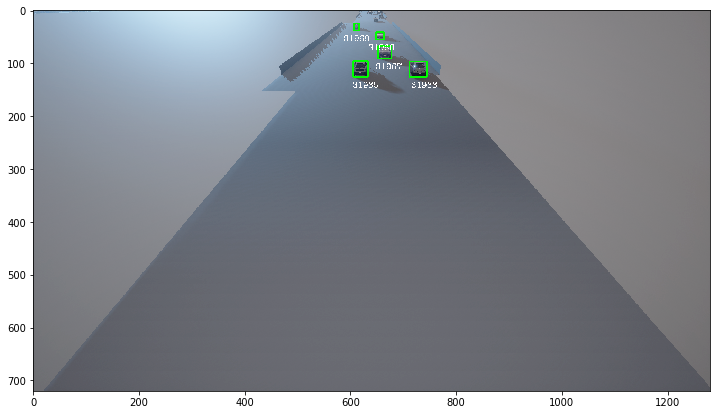

In [451]:
plt.imshow(img)